In [1]:
import numpy as np
import matplotlib.pyplot as plt
from arc import *
import scipy.constants as const
from scipy.special import genlaguerre


For this calculation we assume that two field $E_r$ and $E_b$ are used to couple two hyperfine states of the ground state. To calcualte the effective Rabi frequency we have to sum over all the possible transitions.
$$\Omega= \frac{E_rE_b}{2 \hbar^{2}} \sum_{i} \frac{\left|\left\langle \uparrow\left|\vec{\mu} \cdot \hat{\epsilon_r}\right| i\right\rangle\left\langle i\left|\vec{\mu} \cdot \hat{\epsilon_b}\right| \downarrow\right\rangle\right|}{\Delta_{i}}
$$

In [2]:
def groundStateRamanTransition (atom, Pa, wax, way, qa, Pb, wbx,wby, qb, Delta, f0, mf0, f1, mf1, ne, le, je):
    # Intensity/beam (W/m^2)
    Ia = 2.0 * Pa / (pi * wax*way)
    Ib = 2.0 * Pb / (pi * wbx*wby)
    # Electric field (V/m)
    Ea = np.sqrt( Ia / (epsilon_0 * C_c)) #there might be a factor of sqrt(2) missing
    Eb = np.sqrt( Ib / (epsilon_0 * C_c))
    # Reduced Matrix Element (au)
    ng = atom.groundStateN
    lg = 0
    jg = 0.5
    rme_j = atom.getReducedMatrixElementJ(ng, lg, jg, ne, le, je)
    # Rescale to (Cm)
    rme_j *= C_e * physical_constants["Bohr radius"][0]

    # Qubit level energy separation (rad s-1)
    [A, B] = atom.getHFSCoefficients(ng, lg, jg)
    omega01 = (jg + atom.I) * A * 2.0 * pi

    # Excited State Properties

    # Hyperfine Coefficients (Hz)
    [A, B] = atom.getHFSCoefficients(ne, le, je)
    # Linewidth (rad s-1)
    Gamma = 1.0 / atom.getStateLifetime(ne, le, je)

    # Initialise Output Variables
    OmegaR = np.zeros(np.shape(Delta))
    AC1 = np.zeros(np.shape(Delta))
    AC0 = np.zeros(np.shape(Delta))
    Pe = np.zeros(np.shape(Delta))

    # Loop over excited state energylevels
    for fe in range(int(abs(je - atom.I)), int(1.0 + (je + atom.I))):
        # Hyperfine energy shift (rad s-1)
        Ehfs = 2.0 * np.pi * atom.getHFSEnergyShift(je, fe, A, B)
        for mfe in range(max(-fe, min(mf1, mf0) - 1), 1 + min(fe, max(mf1, mf0) + 1)):

            # Rabi frequency of each laser from each transition (rad s-1)
            Omaf0 = Ea * rme_j / hbar * atom.getSphericalDipoleMatrixElement(f0, mf0, fe, mfe, qa) \
                * atom._reducedMatrixElementFJ(jg, f0, je, fe)

            Omaf1 = Ea * rme_j / hbar * atom.getSphericalDipoleMatrixElement(f1, mf1, fe, mfe, qa) \
                * atom._reducedMatrixElementFJ(jg, f1, je, fe)

            Ombf0 = Eb * rme_j / hbar * atom.getSphericalDipoleMatrixElement(f0, mf0, fe, mfe, qb) \
                * atom._reducedMatrixElementFJ(jg, f0, je, fe)

            Ombf1 = Eb * rme_j / hbar * atom.getSphericalDipoleMatrixElement(f1, mf1, fe, mfe, qb) \
                * atom._reducedMatrixElementFJ(jg, f1, je, fe)

            # AC Stark shift on qubit states
            AC1 += Ombf1**2 / (4 * (Delta - Ehfs)) + \
                Omaf1**2 / (4 * (Delta + omega01 - Ehfs))
            AC0 += Omaf0**2 / (4 * (Delta - Ehfs)) + \
                Ombf0**2 / (4 * (Delta - omega01 - Ehfs))

            # Two-Photon Rabi Frequency
            OmegaR += Omaf0 * Ombf1 / (2 * (Delta - Ehfs))

            # Excitated state population Pe
            Pe += 0.5 * Omaf0**2 / (2 * (Delta - Ehfs)**2) + 0.5 * Ombf1**2 / (2 * (Delta - Ehfs)**2) \
                + 0.5 * Omaf1**2 / (2 * (Delta + omega01 - Ehfs)**2) + \
                0.5 * Ombf0**2 / (2 * (Delta - omega01 - Ehfs)**2)

    # Total Differential Shift
    AC = AC0 - AC1

    # Pi-rotation time (s)
    tau_pi = pi / abs(OmegaR)
    # Spontaneous Emission Probability
    Psc = Gamma * tau_pi * Pe

    return OmegaR, AC, Psc

In [4]:
# Test Raman Transition Calculation
#==================================
Rb87=Rubidium87()
#Laser Parameters
P= 50e-3 
w0x= 40e-6
w0y= 200e-6
Pa = P/2; wax = w0x; way = w0y; qa = 1;
Pb = P/2; wbx = w0x; wby = w0y; qb = 1;


#Detuning
Delta0 = -200e9 * 2 * np.pi

#D1 Line
ne = 5; le = 1; je = 0.5; #excited state
f1 = 2; mf1 = 0; f0 = 1; mf0 = 0;# qubit states
OmR, AC, Psc = groundStateRamanTransition(Rb87, Pa, wax,way, qa,
                                             Pb, wbx,wby, qb,
                                             Delta0,
                                             f0, mf0, f1, mf1,
                                             ne, le, je)
print('\nRaman Transitions |%d,%d> to |%d,%d> via %dP_%d/2'
      % (f1, mf1, f0, mf0, ne, je*2))
print('\tParameters:\tDelta/2pi = %2.f GHz, Pa = %1.2f mW, wax = %2.1f um, way = %2.1f um, Pa = %1.2f mW, wbx = %2.1f um, wby = %2.1f um' \
      % (Delta0 / 2.0 / np.pi * 1e-9, Pa * 1e3, wax * 1e6, way * 1e6, Pb * 1e3, wbx * 1e6, wby * 1e6))
print('\tResults:\tOmR/2pi = %2.5f MHz, AC/2pi = %2.5f MHz, Psc = %f'
      % (OmR / 2.0 / np.pi * 1e-6, AC / 2.0 / np.pi * 1e-6, Psc))


#D2 Line
ne = 5; le = 1; je = 1.5; #excited state
f1 = 2; mf1 = 0; f0 = 1; mf0 = 0;# qubit states
OmR, AC, Psc = groundStateRamanTransition(Rb87, Pa, wax,way, qa,
                                             Pb, wbx,wby, qb,
                                             Delta0,
                                             f0, mf0, f1, mf1,
                                             ne, le, je)
print('\nRaman Transitions |%d,%d> to |%d,%d> via %dP_%d/2'
      % (f1, mf1, f0, mf0, ne, je*2))
print('\tParameters:\tDelta/2pi = %2.f GHz, Pa = %1.2f mW, wax = %2.1f um, way = %2.1f um, Pa = %1.2f mW, wbx = %2.1f um, wby = %2.1f um' \
      % (Delta0 / 2.0 / np.pi * 1e-9, Pa * 1e3, wax * 1e6, way * 1e6, Pb * 1e3, wbx * 1e6, wby * 1e6))
print('\tResults:\tOmR/2pi = %2.5f MHz, AC/2pi = %2.5f MHz, Psc = %f'
      % (OmR / 2.0 / np.pi * 1e-6, AC / 2.0 / np.pi * 1e-6, Psc))



Raman Transitions |2,0> to |1,0> via 5P_1/2
	Parameters:	Delta/2pi = -200 GHz, Pa = 25.00 mW, wax = 40.0 um, way = 200.0 um, Pa = 25.00 mW, wbx = 40.0 um, wby = 200.0 um
	Results:	OmR/2pi = 0.91528 MHz, AC/2pi = 0.03130 MHz, Psc = 0.000181

Raman Transitions |2,0> to |1,0> via 5P_3/2
	Parameters:	Delta/2pi = -200 GHz, Pa = 25.00 mW, wax = 40.0 um, way = 200.0 um, Pa = 25.00 mW, wbx = 40.0 um, wby = 200.0 um
	Results:	OmR/2pi = -0.91418 MHz, AC/2pi = 0.06022 MHz, Psc = 0.000382


In [38]:
C_c

299792458.0

# Carrier Rabi Flops

In [2]:
def P_thermal(n, nbar):
    return 1/(1+nbar)*(nbar/(1+nbar))**n


def carr_laguerre(n, eta, Omega_0=1):
    
    prefactor = Omega_0 * np.exp(-(eta**2)/2) 
    laguerre_poly = genlaguerre(n, 0)(eta**2)
    return prefactor*laguerre_poly

array([2.33196159e-01, 1.46827211e-01, 9.24467627e-02, 5.82072209e-02,
       3.66489910e-02, 2.30752906e-02, 1.45288867e-02, 9.14781754e-03,
       5.75973697e-03, 3.62650105e-03, 2.28335252e-03, 1.43766640e-03,
       9.05197362e-04, 5.69939080e-04, 3.58850532e-04, 2.25942927e-04,
       1.42260362e-04, 8.95713388e-05, 5.63967689e-05])

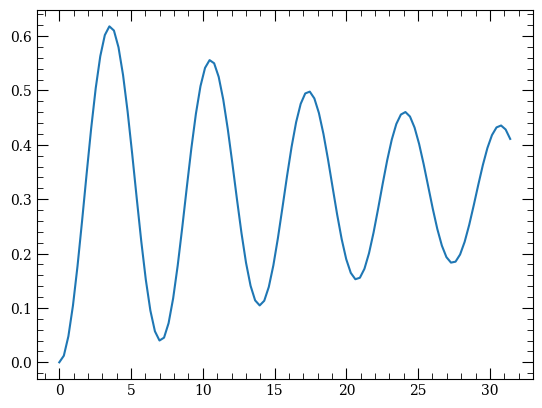

In [27]:
eta = 0.2
n_bar= 1.7
ns = np.arange(1,20) #list of fock states

ts =np.linspace(0,10*np.pi,100)
Prob_up = []

for t in ts:
    # for each time we now calculate the probability of being in spin up
    Prob_up_t = 0
    for n in ns:
        Omega_carr_n= carr_laguerre(n, eta) # calculate the carrier Rabi frequency given a fock state n
        Pn = P_thermal(n, n_bar) # probability of occupying a given fock state
        Prob_up_t += Pn/2 * (1-np.cos(Omega_carr_n * t) )#sums up all the contributions from the various fock states assuming a thermal distribution
    
    Prob_up.append(Prob_up_t)

plt.plot(ts, Prob_up)
P_thermal(ns, n_bar)

## Add extra modes

In [17]:
def carr_laguerre_3_modes(n, etas, Omega_0=1):
    omega_carrier = Omega_0
    for eta in etas:
        prefactor = Omega_0 * np.exp(-(eta**2)/2) 
        laguerre_poly = genlaguerre(n, 0)(eta**2)
        omega_carrier *= prefactor*laguerre_poly
    
    return omega_carrier

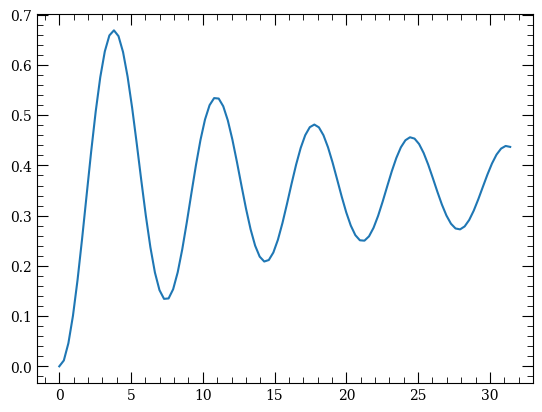

In [29]:
nbar_ax = 4.7
nbar_rad = 1.7

eta_ax = 0.2
eta_rad = 0.1

ns = np.arange(1,20) #list of fock states

ts =np.linspace(0,10*np.pi,100)
Prob_up = []

for t in ts:
    # for each time we now calculate the probability of being in spin up
    Prob_up_t = 0
    for n in ns:
        Omega_carr_n= carr_laguerre_3_modes(n, [eta_ax, eta_rad]) # calculate the carrier Rabi frequency given a fock state n
        Pn_ax = P_thermal(n, nbar_ax) # probability of occupying a given fock state axially
        Pn_rad = P_thermal(n, nbar_rad) # probability of occupying a given fock state

        Prob_up_t += (Pn_ax+Pn_rad)/4 * (1-np.cos(Omega_carr_n * t)) #sums up all the contributions from the various fock states assuming a thermal distribution
    
    Prob_up.append(Prob_up_t)

plt.plot(ts, Prob_up)

# Sideband cooling

## Paramaters

In [36]:
nbar_ax = 4.7
nbar_rad = 1.7

eta_ax = 0.2
eta_rad = 0.1

sbc_wavl = 780e-9
eff_k_rad= 2*pi/sbc_wavl * np.sqrt(2) # sqrt(2) becasue the beams are at 90 deg
def eta(k, omega, angle= pi/4, mass= 87*const.u):
    return k*np.cos(angle) *np.sqrt(const.hbar/(2*mass*omega) )

eff_k_rad= 2*pi/sbc_wavl * np.cos() # sqrt(2) becasue the beams are at 90 deg

eta_ax = eta(eff_k_rad,omega=2*pi*30e3, angle= pi/4)
eta_rad = eta(eff_k,omega=2*pi*150e3, angle= 0*pi/4)

print("eta axial: "+ str(eta_ax))
print("eta radial: "+ str(eta_rad))

eta axial: 0.35446520612583116
eta radial: 0.2241834805277391


In [37]:
k313=2*pi/313e-9 * np.sqrt(2)
eta(k313,angle=pi/4,mass= 9*const.u,omega=2*pi*2e6)

0.3363627372758047

In [38]:
def thermal_dist(n, nbar):
    return 1/(1+nbar)*(nbar/(1+nbar))**n


def RSB_laguerre(n, eta, Omega_0=1):
    
    prefactor = eta * Omega_0 * np.exp(-(eta**2)/2) * np.sqrt(1/n)
    laguerre_poly = genlaguerre(n-1, 1)(eta**2)
    return prefactor*laguerre_poly
    

Text(0, 0.5, 'rabi frequency')

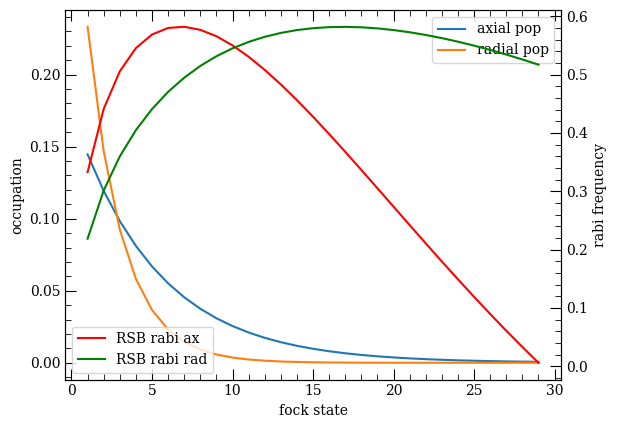

In [39]:
ns= np.arange(1,30)
rsb_freq_ax =[]
rsb_freq_rad =[]
for n in ns:
    rsb_freq_ax.append(RSB_laguerre(n, eta_ax))
    rsb_freq_rad.append(RSB_laguerre(n, eta_rad))

fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(ns, thermal_dist(ns, nbar_ax), label= "axial pop")
ax1.plot(ns, thermal_dist(ns, nbar_rad), label ="radial pop")
ax2.plot(ns, rsb_freq_ax, 'red',label='RSB rabi ax')
ax2.plot(ns, rsb_freq_rad, 'green', label='RSB rabi rad')
ax1.legend()
ax2.legend()

ax1.set_xlabel("fock state")
ax1.set_ylabel("occupation")
ax2.set_ylabel("rabi frequency")